<a href="https://colab.research.google.com/github/guillermodulcey/TesisCinvestav/blob/main/MSR/ModeloMSR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencias



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
class DatasetAlignment():
  def __init__(self, size=3000, val_size=2000):
    text_dataset = tf.keras.preprocessing.text_dataset_from_directory(
      '/content/drive/MyDrive/Datasets/TranscriptionsB',
      labels="inferred",
      label_mode="int",
      class_names=None,
      batch_size=2000,
      max_length=None,
      shuffle=True,
      seed=123,
      validation_split=.2,
      subset='training',
      follow_links=False,
    )

    text_validation = tf.keras.preprocessing.text_dataset_from_directory(
      '/content/drive/MyDrive/Datasets/TranscriptionsB',
      labels="inferred",
      label_mode="int",
      class_names=None,
      batch_size=2000,
      max_length=None,
      shuffle=True,
      seed=123,
      validation_split=.2,
      subset='validation',
      follow_links=False,
    )

    (colorectal_dataset, colorectal_validation), colorectal_info = tfds.load('colorectal_histology', 
                                                      split=[f'train[:{size}]', f'train[{size}:]'], 
                                                      shuffle_files=False, 
                                                      with_info=True, 
                                                      as_supervised=True)

    self.cats_dogs = colorectal_dataset.take(size)
    self.reviews = text_dataset.take(size)

    self.validation_cats_dogs = colorectal_validation.take(val_size)
    self.validation_reviews = text_validation.take(val_size)

  def train_text(self, max_words=10000):
    for texts, t_labels in self.reviews.take(1):  # only take first batch of dataset
      numpy_text = texts.numpy()
      numpy_t_labels = t_labels.numpy()

    train = pd.DataFrame()
    train['text'] = pd.Series(numpy_text)
    train['label'] = pd.Series(numpy_t_labels)

    train_labels = train['label']
    train_text = train['text']

    train_text = train_text.apply(lambda x: x.decode('utf-8'))

    self.tokenizer = Tokenizer(max_words, oov_token='<OOV>')

    self.tokenizer.fit_on_texts(train_text.to_list())
    self.total_words = len(self.tokenizer.word_index)+1

    train_sequences = self.tokenizer.texts_to_sequences(train_text.to_list())
    train_padded = pad_sequences(train_sequences)

    train_labels = np.array(train_labels.to_list())

    self.max_sequence_length = train_padded.shape[1]

    self.reviews = tf.data.Dataset.from_tensor_slices((train_padded, train_labels))

    ## Validation
    for texts, t_labels in self.validation_reviews.take(1):  # only take first batch of dataset
      validation_text = texts.numpy()
      validation_labels = t_labels.numpy()

    validation = pd.DataFrame()
    validation['text'] = pd.Series(validation_text)
    validation['label'] = pd.Series(validation_labels)

    validation_labels = validation['label']

    validation_text = validation['text']
    validation_text = validation_text.apply(lambda x: x.decode('utf-8'))

    validation_sequences = self.tokenizer.texts_to_sequences(validation_text.to_list())
    validation_padded = pad_sequences(validation_sequences, maxlen=self.max_sequence_length)

    validation_labels = np.array(validation_labels.to_list())

    self.validation_reviews = tf.data.Dataset.from_tensor_slices((validation_padded, validation_labels))

  def align(self):
    one_i = self.cats_dogs.filter(lambda x,y: y == 0)
    two_i = self.cats_dogs.filter(lambda x,y: y == 1)
    
    one_t = self.reviews.filter(lambda x,y: y == 0)
    two_t = self.reviews.filter(lambda x,y: y == 1)
    
    one_z = tf.data.Dataset.zip((one_i, one_t))
    two_z = tf.data.Dataset.zip((two_i, two_t))

    merged = one_z.concatenate(two_z)

    self.cats_dogs = merged.map(lambda x, y: x)
    self.reviews = merged.map(lambda x, y: y)

    return self.cats_dogs, self.reviews

  def validation(self, size=10000):
    one_i = self.validation_cats_dogs.filter(lambda x,y: y == 0)
    two_i = self.validation_cats_dogs.filter(lambda x,y: y == 1)

    one_t = self.validation_reviews.filter(lambda x,y: y == 0)
    two_t = self.validation_reviews.filter(lambda x,y: y == 1)

    one_z = tf.data.Dataset.zip((one_i, one_t))
    two_z = tf.data.Dataset.zip((two_i, two_t))

    merged = one_z.concatenate(two_z)

    self.validation_cats_dogs = merged.map(lambda x, y: x)
    self.validation_reviews = merged.map(lambda x, y: y)

    return self.validation_cats_dogs, self.validation_reviews


In [ ]:
from scipy.spatial import distance

class SOM():
  def __init__(self, m, n, inputs, seed=123):
    self.m = m
    self.n = n
    self.dim = inputs.shape[1]
    self.std_coeff = 0.5

    self.initial_learning_rate = 0.1
    self.initial_radius = np.max((self.m, self.n)) / 2
    self.inputs = inputs
    self.w_init = tf.random_uniform_initializer(maxval=1, seed=seed)
    self.weights = tf.Variable(initial_value=self.w_init(shape=[self.m * self.n, self.dim], dtype="float32"), name='weights')
    self.location_vects = tf.constant(np.array(list(self.neuron_locations())), name='Location_Vectors')

  def neuron_locations(self):
    for i in range(self.m):
      for j in range(self.n):
          yield np.array([i, j])

  def train(self, max_epochs):
    tf_inputs = tf.Variable(self.inputs)
    for epoch in range(1, max_epochs+1):
      mean = tf.reduce_mean(self.weights)
      std = tf.sqrt(tf.reduce_mean(tf.math.squared_difference(self.weights, mean)))
      max = tf.reduce_max(self.weights)
      min = tf.reduce_min(self.weights)

      squared_distance = tf.reduce_sum(tf.pow(tf.subtract(tf.expand_dims(self.weights, axis=0),tf.expand_dims(tf_inputs, axis=1)), 2), 2)
      # BMU_Indices (Best matching unit)
      bmu_indices = tf.argmin(squared_distance, axis=1)
      # BMU_Locations
      bmu_locs = tf.reshape(tf.gather(self.location_vects, bmu_indices), [-1, 2])
      # Learning_Rate
      radius = tf.subtract(self.initial_radius, tf.multiply(epoch, tf.divide(tf.cast(tf.subtract(self.initial_radius, 1), tf.float32),
                                            tf.cast(tf.subtract(max_epochs+1, 1), tf.float32))))
      alpha = tf.multiply(self.initial_learning_rate, tf.subtract(1.0, tf.divide(tf.cast(epoch, tf.float32),
                                                  tf.cast(max_epochs+1, tf.float32))))
      bmu_distance_squares = tf.reduce_sum(tf.pow(tf.subtract(tf.expand_dims(self.location_vects, axis=0),
                                                  tf.expand_dims(bmu_locs, axis=1)), 2), 2)
      neighbourhood_func = tf.exp(tf.divide(tf.negative(tf.cast(bmu_distance_squares, "float32")), tf.multiply(
                                                        tf.square(tf.multiply(radius, self.std_coeff)), 2)))
      learning_rate_op = tf.multiply(neighbourhood_func, alpha)
      # Update_Weights
      numerators = tf.reduce_sum(tf.multiply(tf.expand_dims(learning_rate_op, axis=-1), tf.expand_dims(tf_inputs, axis=1)), axis=0)
      denominators = tf.expand_dims(tf.reduce_sum(learning_rate_op, axis=0) + float(1e-12), axis=-1)
        
      self.weights = tf.divide(numerators, denominators)
    return self.weights

  def transform(self):
    result_matrix = list()
    for i, row in enumerate(self.inputs):
      image_document = np.zeros(shape=self.m*self.n, dtype=np.float32)
      for j, node in enumerate(self.weights.numpy()):
        #image_document[j]=np.dot(row, node.weights)
        image_document[j] = 1.0/distance.euclidean(row, node)
      mn = image_document.min()
      mx = image_document.max()
      image_document = ((image_document-mn)/(mx-mn)*255.9).astype(np.uint8)
      image_document = image_document.reshape(self.m, self.n)
      result_matrix.append(image_document)

    return np.array(result_matrix)

  def save(self, name):
    np.save(f'drive/MyDrive/Models/{name}.npy', self.weights)

  def load(self, name):
    self.weights = np.load(f'drive/MyDrive/Models/{name}.npy')
    self.weights = tf.Variable(self.weights)

# Cargar Dataset

In [ ]:
da = DatasetAlignment()

Found 1619 files belonging to 2 classes.
Using 1296 files for training.
Found 1619 files belonging to 2 classes.
Using 323 files for validation.


Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteFLTRDR/colorectal_histology-train.tfrecord


Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [ ]:
da.train_text()
cats_dogs, reviews = da.align()

In [ ]:
total_words = da.total_words
max_sequence_length = da.max_sequence_length

# Texto

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
URL = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2"
feature_extractor = hub.KerasLayer(URL, input_shape=[], dtype=tf.string)

weights = feature_extractor.get_weights()
weights = np.squeeze(weights)

embedding_matrix = np.zeros((total_words,50))

embedding_matrix[1:] = weights[:total_words-1]

In [ ]:
input_text = tf.keras.Input(shape=(max_sequence_length, ), name="input_text")

embedding_layer = tf.keras.layers.Embedding(total_words, 50, input_length=max_sequence_length, weights=[embedding_matrix], trainable=True)(input_text)
rnn_layer1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(10, return_sequences=True))(embedding_layer)
rnn_layer2 = tf.keras.layers.GRU(10)(rnn_layer1)
dense_layer = tf.keras.layers.Dense(16, 'relu')(rnn_layer2)

x = tf.keras.layers.Dense(1, 'sigmoid')(dense_layer)

text_model = tf.keras.Model(inputs=[input_text], outputs=[x])

text_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text (InputLayer)      [(None, 69)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 69, 50)            208300    
_________________________________________________________________
bidirectional (Bidirectional (None, 69, 20)            3720      
_________________________________________________________________
gru_1 (GRU)                  (None, 10)                960       
_________________________________________________________________
dense (Dense)                (None, 16)                176       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 213,173
Trainable params: 213,173
Non-trainable params: 0
_______________________________________________________

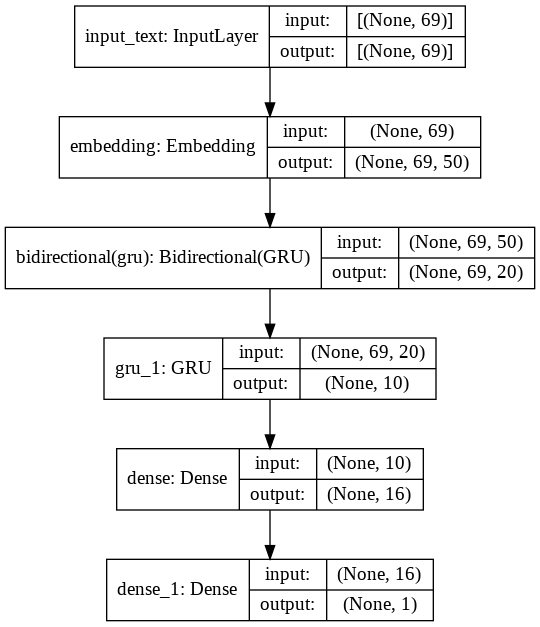

In [ ]:
tf.keras.utils.plot_model(text_model, "text.png", show_shapes=True)

In [ ]:
batched_reviews = reviews.batch(32).prefetch(1)

In [ ]:
class Stopper(tf.keras.callbacks.Callback):
  def __init__(self, metric, value):
    super().__init__()
    self.metric = metric
    self.value = value

  def on_epoch_end(self, epoch, logs={}):
    if(logs.get(self.metric)>self.value):
      print(f"\nReached {self.value} {self.metric} or above")
      self.model.stop_training = True

callbacks = Stopper('accuracy', 0.9)

In [ ]:
text_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

epochs=10
history = text_model.fit(
    batched_reviews,
    epochs=epochs,
    # callbacks=[callbacks]
    )

Epoch 1/5
24/24 [==============================] - 8s 186ms/step - loss: 0.5104 - accuracy: 0.7880
Epoch 2/5
24/24 [==============================] - 5s 190ms/step - loss: 0.3607 - accuracy: 0.9240
Epoch 3/5
24/24 [==============================] - 5s 190ms/step - loss: 0.2627 - accuracy: 0.9507
Epoch 4/5
24/24 [==============================] - 5s 189ms/step - loss: 0.1684 - accuracy: 0.9667
Epoch 5/5
24/24 [==============================] - 5s 191ms/step - loss: 0.1116 - accuracy: 0.9707


In [ ]:
extract_text_model = tf.keras.Model(inputs=[input_text], outputs=[dense_layer])

extract_text_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text (InputLayer)      [(None, 69)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 69, 50)            208300    
_________________________________________________________________
bidirectional (Bidirectional (None, 69, 20)            3720      
_________________________________________________________________
gru_1 (GRU)                  (None, 10)                960       
_________________________________________________________________
dense (Dense)                (None, 16)                176       
Total params: 213,156
Trainable params: 213,156
Non-trainable params: 0
_________________________________________________________________


In [ ]:
text_result = extract_text_model.predict(reviews.batch(32), verbose=1)

24/24 [==============================] - 5s 185ms/step


In [ ]:
extract_text_model.save('drive/MyDrive/Models/text_model_som_med_b.tf')

INFO:tensorflow:Assets written to: drive/MyDrive/Models/text_model_som_med_b.tf/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Models/text_model_som_med_b.tf/assets


In [ ]:
grid = 10
train = 2000
#Training SOM
som = SOM(grid, grid, text_result)
som.train(train)
text_images_matrix = som.transform()

In [ ]:
som.save('som_text_tf_b')

In [ ]:
labels = reviews.batch(32)

y = np.concatenate([y for x, y in labels], axis=0)

In [ ]:
y.shape

(750,)

In [ ]:
y2 = [yc.numpy() for _ , yc in cats_dogs]

In [ ]:
y2 = np.array(y2)

y2.shape

(750,)

In [ ]:
np.array_equal(y, y2)

True

In [ ]:
len(text_images_matrix)

750

# Imágenes

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
IMAGE_RES = 299

resize_function = lambda x, y: (tf.image.resize(x, (IMAGE_RES, IMAGE_RES))/255.0, y)

In [ ]:
URL = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
feature_extractor.trainable = False

image_model = tf.keras.Sequential([
  feature_extractor
])

image_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________


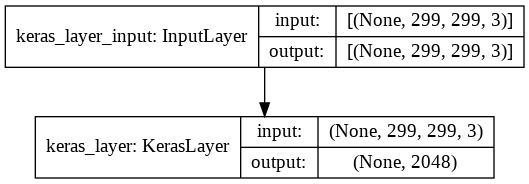

In [ ]:
tf.keras.utils.plot_model(image_model, "image.png", show_shapes=True)

In [ ]:
prediction_batches = cats_dogs.map(resize_function).batch(32)

image_result = image_model.predict(prediction_batches, verbose=1)

25/25 [==============================] - 34s 283ms/step


In [ ]:
image_model.save('drive/MyDrive/Models/image_model_som_med_b.tf')

INFO:tensorflow:Assets written to: drive/MyDrive/Models/image_model_som_med_b.tf/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Models/image_model_som_med_b.tf/assets


In [ ]:
image_result.shape

(750, 2048)

In [ ]:
#Training SOM
som2 = SOM(grid, grid, image_result)
som2.train(train)
image_images_matrix = som2.transform()

In [ ]:
som2.save('som_image_tf_b')

In [ ]:
image_images_matrix[0]

array([[255, 173, 145, 107,  95,  99, 103,  93,  81,  80],
       [236, 217, 156, 124, 113, 133, 127,  90, 103, 119],
       [119, 154, 125, 116, 125, 174, 131,  92, 131, 131],
       [ 55,  79, 125, 134, 138, 169, 142, 107, 105, 136],
       [ 69,  67,  80, 120, 141, 133, 109,  98, 110, 101],
       [ 71,  57,  87, 126, 132, 125, 117,  80, 129, 107],
       [ 57,  75,  76,  76,  89,  84,  79,  62,  81,  86],
       [ 63,  58,  55,  69,  63,  52,  41,  39,  52,  65],
       [ 42,  46,  35,  24,  29,  28,  48,  47,  51,  61],
       [ 20,  33,  27,  21,   7,   0,  27,  42,  67,  59]], dtype=uint8)

In [ ]:
image1 = image_images_matrix[100].flatten()
text1 = text_images_matrix[100].flatten()

spectral1 = list(zip(image1, text1, np.zeros_like(image1)))

np_spectral1 = np.array(spectral1)

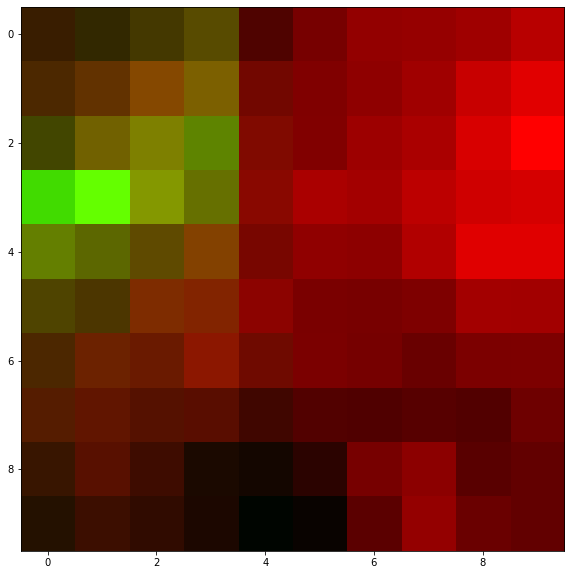

In [ ]:
plt.figure(figsize=(10,10))
plt.grid(False)
plt.imshow(np_spectral1.reshape(grid,grid,3))
plt.show()

In [ ]:
image0 = image_images_matrix[600].flatten()
text0 = text_images_matrix[600].flatten()

spectral0 = list(zip(image0, text0, np.zeros_like(image0)))

np_spectral0 = np.array(spectral0)

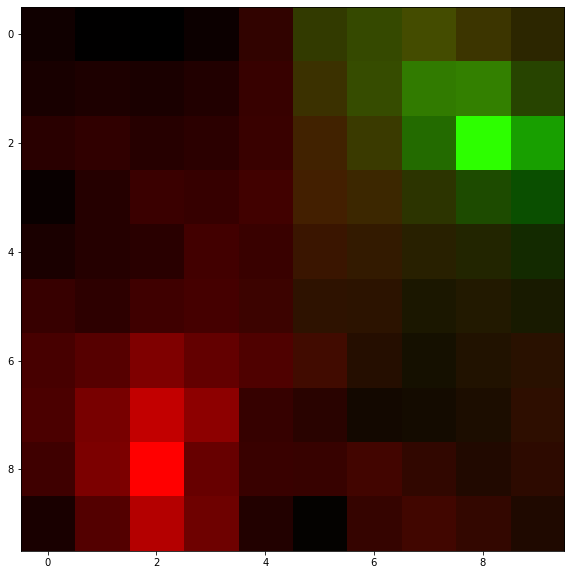

In [ ]:
plt.figure(figsize=(10,10))
plt.grid(False)
plt.imshow(np_spectral0.reshape(grid,grid,3))
plt.show()

In [ ]:
spectral_images = []

for i, image in enumerate(image_images_matrix):
  r = image.flatten()
  g = text_images_matrix[i].flatten()
  b = np.zeros_like(r)
  spectral = list(zip(r, g, b))
  spectral_images.append(np.array(spectral).reshape(grid,grid,3))

In [ ]:
spectral_data = tf.data.Dataset.from_tensor_slices((spectral_images, y))

In [ ]:
spectral_train_batches = spectral_data.map(resize_function).batch(32).prefetch(1)

In [ ]:
spectral_train_batches
# <PrefetchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.int64)>

<PrefetchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.int64)>

In [ ]:
tf.keras.backend.clear_session()

URL = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
feature_extractor.trainable = False

spectral_model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(1, 'sigmoid')
])

spectral_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
spectral_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

epochs=10
history = spectral_model.fit(
    spectral_train_batches,
    epochs=epochs,
    # callbacks=[callbacks]
    )

Epoch 1/10
24/24 [==============================] - 5s 120ms/step - loss: 0.9349 - accuracy: 0.6200
Epoch 2/10
24/24 [==============================] - 3s 123ms/step - loss: 0.6481 - accuracy: 0.6507
Epoch 3/10
24/24 [==============================] - 3s 123ms/step - loss: 0.4048 - accuracy: 0.8187
Epoch 4/10
24/24 [==============================] - 3s 121ms/step - loss: 0.4746 - accuracy: 0.7760
Epoch 5/10
24/24 [==============================] - 3s 121ms/step - loss: 0.4334 - accuracy: 0.8040
Epoch 6/10
24/24 [==============================] - 3s 122ms/step - loss: 0.4301 - accuracy: 0.8067
Epoch 7/10
24/24 [==============================] - 3s 121ms/step - loss: 0.4166 - accuracy: 0.8133
Epoch 8/10
24/24 [==============================] - 3s 122ms/step - loss: 0.4048 - accuracy: 0.8160
Epoch 9/10
24/24 [==============================] - 3s 121ms/step - loss: 0.3938 - accuracy: 0.8200
Epoch 10/10
24/24 [==============================] - 3s 120ms/step - loss: 0.3834 - accuracy: 0.8280

In [ ]:
spectral_model.save('drive/MyDrive/Models/spectral_model_som_med_b.tf')

INFO:tensorflow:Assets written to: drive/MyDrive/Models/spectral_model_som_med_b.tf/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Models/spectral_model_som_med_b.tf/assets
